# Machine Learning for Telecom with RandomCutForest

## Introduction

Machine Learning for Telecom with Random Cut Forest is a mode of unsupervised anomaly detection on timeseries data with Amazon Random Cut Forest algorithm. The notebook demonstrates the usage of Call Service Duration in a CDR (Call Detail Record) dataset for Anomaly detection.

- _In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the Call Detail Record (CDR)  dataset of Telecom data. We will use this model to predict anomalous events by emitting an "anomaly score" for each data point._


In [1]:
%config IPCompleter.greedy=True

Using S3 Select, enables applications to retrieve only a subset of data from an object by using simple SQL expressions. By using S3 Select to retrieve only the data, you can achieve drastic performance increases – in many cases you can get as much as a 400% improvement.

In [2]:
import urllib.request
import boto3
import pandas as pd
from io import StringIO

# Using S3 Select to retrieve data 
s3 = boto3.client('s3')
bucket_name = '<%bucket_name%>'  # <-- use your own bucket, here
version = '%%VERSION%%'
file_name = 'machine-learning-for-all/{}/data/cdr-stop/cdr_stop.csv'.format(version)  

sql_stmt = """SELECT * FROM s3object"""

# making the request
req = s3.select_object_content(
    Bucket=bucket_name,
    Key=file_name,
    ExpressionType='SQL',
    Expression=sql_stmt,
    InputSerialization = {'CSV': {'FileHeaderInfo': 'Use'}},
    OutputSerialization = {'CSV': {}},
)

records = []

# looping through the payload of the AWS EventStream and getting one or more Records and Stats
for event in req['Payload']:
    if 'Records' in event:
        records.append(event['Records']['Payload'])
    elif 'Stats' in event:
        stats = event['Stats']['Details']


# converting the byte strings to strings and then joining them together to form one large string
file_str = ''.join(r.decode('utf-8') for r in records)


In [3]:
dataset = pd.read_csv(StringIO(file_str),header=None, usecols=[5,13], names=['Start_Time','Duration'])
print(len(dataset))

dataset.plot(title='Call Service Duration')

273928


## Exploration of Data

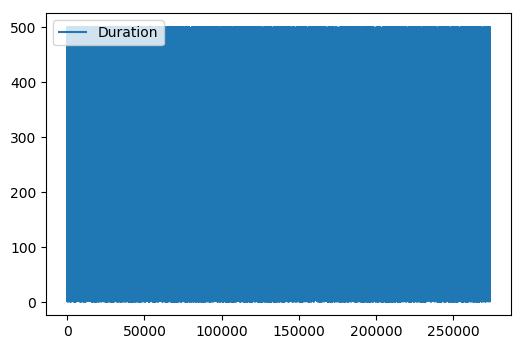

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

dataset.plot()

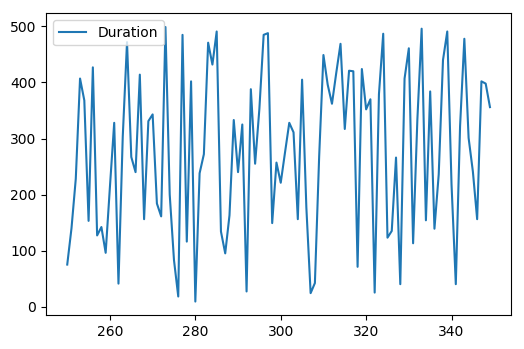

In [5]:
dataset[250:350].plot()

In [6]:
def convert_and_upload_training_data(
    ndarray, bucket, prefix, filename='data.pbr'):
    import boto3
    import os
    from sagemaker.amazon.common import numpy_to_record_serializer

    # convert Numpy array to Protobuf RecordIO format
    serializer = numpy_to_record_serializer()
    buffer = serializer(ndarray)

    # upload to S3
    s3_object = os.path.join(prefix, 'train', filename)
    boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(buffer)
    s3_path = 's3://{}/{}'.format(bucket, s3_object)
    return s3_path

bucket = bucket_name # <-- use your own bucket, here
prefix = 'ml-telecom/sagemaker/randomcutforest'
s3_train_data = convert_and_upload_training_data(
    dataset.Duration.as_matrix().reshape(-1,1),
    bucket,
    prefix)


## Hyperparameters

In [7]:
import sagemaker
from sagemaker import RandomCutForest
from sagemaker import get_execution_role

execution_role = get_execution_role()
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(dataset.Duration.as_matrix().reshape(-1,1)))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-09-27-19-54-35-890


..................

Docker entrypoint called with argument(s): train
[09/27/2018 19:57:22 INFO 139997971146560] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[09/27/2018 19:57:22 INFO 139997971146560] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'1', u'num_samples_per_tree': u'512', u'num_trees': u'50'}
[09/27/2018 19:57:22 INFO 139997971146560] Final configuration: {u'_ftp_port': 8999, u'num_samples_per_tree': u'512', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u

Billable seconds: 77


## Inference

In [8]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-09-27-19-57-47-577
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-09-27-19-54-35-890


---------------------------------------------------------------------------------------!

In [9]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [10]:
dataset_numpy = dataset.Duration.as_matrix().reshape(-1,1)
print(dataset_numpy[:6])
results = rcf_inference.predict(dataset_numpy[:6])

[[ 78]
 [476]
 [190]
 [395]
 [440]
 [458]]


## Calculating anomaly Scores

In [11]:
results = rcf_inference.predict(dataset_numpy)
scores = [datum['score'] for datum in results['scores']]

dataset['score'] = pd.Series(scores, index=dataset.index)
dataset.head()

,Start_Time,Duration,score
0,07/15/2018,78,0.831256
1,07/15/2018,476,0.983720
2,07/15/2018,190,0.839513
3,07/15/2018,395,0.826109
4,07/15/2018,440,0.866195


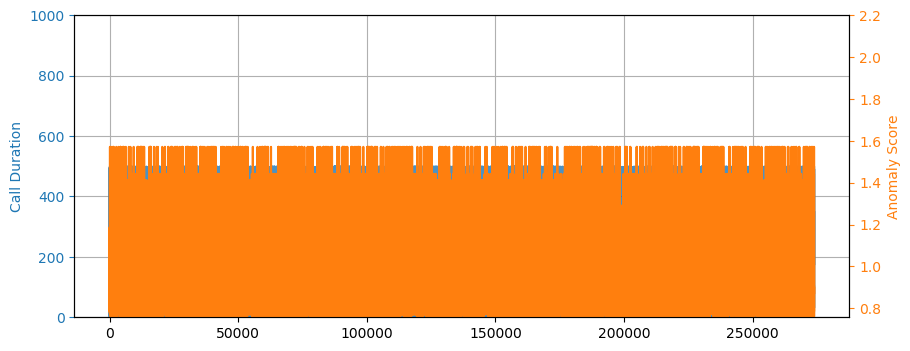

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(dataset)

dataset_subset = dataset[start:end]

ax1.plot(dataset_subset['Duration'], color='C0', alpha=0.8)
ax2.plot(dataset_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Call Duration', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 1000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

- _Below we print and plot any data points with scores greater than 3 standard deviations from the mean score._


In [13]:
score_mean = dataset['score'].mean()
score_std = dataset['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = dataset_subset[dataset_subset['score'] > score_cutoff]
anomalies

,Start_Time,Duration,score
14,07/15/2018,496,1.183614
25,07/15/2018,4,1.182566
77,07/15/2018,3,1.188866
91,07/15/2018,1,1.442088
120,07/15/2018,495,1.160644
126,07/15/2018,500,1.571325
141,07/15/2018,2,1.267461
146,07/15/2018,499,1.412903
273,07/15/2018,499,1.412903
333,07/15/2018,496,1.183614


- _Note that algorithm managed to capture these events along with quite a few others. Below we add these anomalies to the score plot._

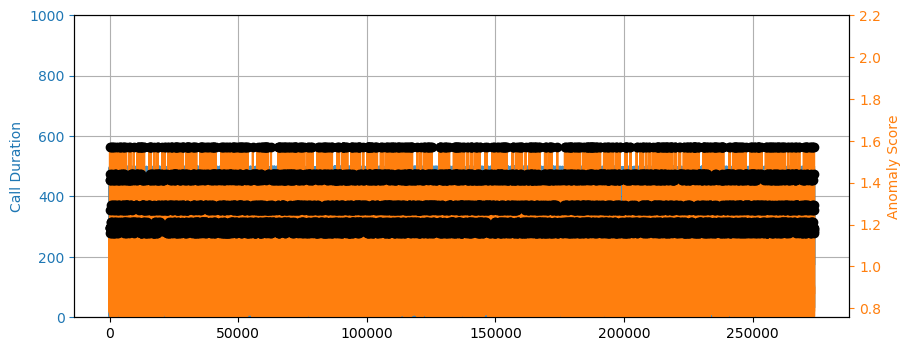

In [14]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

We make use of a windowing technique called "shingling". This is especially useful when working with periodic data with known period. Treat a period of P datapoints as a single datapoint of feature length P and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points x1,x2,…,xN∈ℝ

then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [15]:
import numpy as np

def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data-shingle_size, shingle_size))
    
    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data

shingle_size = 48
prefix_shingled = 'sagemaker/randomcutforest_shingled'
dataset_shingled = shingle(dataset.Duration, shingle_size)
print(dataset_shingled)

[[ 78. 476. 190. ... 294. 382. 119.]
 [476. 190. 395. ... 382. 119.  74.]
 [190. 395. 440. ... 119.  74. 175.]
 ...
 [129. 100. 275. ... 363.  83. 267.]
 [100. 275. 438. ...  83. 267. 437.]
 [275. 438. 386. ... 267. 437. 428.]]


In [16]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix_shingled),
                      output_path='s3://{}/{}/output'.format(bucket, prefix_shingled),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(dataset_shingled))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-09-27-20-06-01-801


...................
Docker entrypoint called with argument(s): train
[09/27/2018 20:09:01 INFO 140505886754624] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[09/27/2018 20:09:01 INFO 140505886754624] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'48', u'num_samples_per_tree': u'512', u'num_trees': u'50'}
[09/27/2018 20:09:01 INFO 140505886754624] Final configuration: {u'_ftp_port': 8999, u'num_samples_per_tree': u'512', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': 


Billable seconds: 81


In [17]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'appliation/json'
rcf_inference.deserializer = json_deserializer

INFO:sagemaker:Creating model with name: randomcutforest-2018-09-27-20-09-43-796
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-09-27-20-06-01-801


--------------------------------------------------------------!

In [18]:
print(dataset_shingled[:6])
results = rcf_inference.predict(dataset_shingled[:6])

[[ 78. 476. 190. 395. 440. 458. 425.  88. 335. 169. 481. 148.  93. 291.
  496. 173. 223. 490. 213.  34. 289.  57. 413. 205. 281.   4. 217. 368.
  373. 202. 174. 365. 142. 172. 182. 390. 318. 147. 185. 200. 477.  73.
   56.  43. 321. 294. 382. 119.]
 [476. 190. 395. 440. 458. 425.  88. 335. 169. 481. 148.  93. 291. 496.
  173. 223. 490. 213.  34. 289.  57. 413. 205. 281.   4. 217. 368. 373.
  202. 174. 365. 142. 172. 182. 390. 318. 147. 185. 200. 477.  73.  56.
   43. 321. 294. 382. 119.  74.]
 [190. 395. 440. 458. 425.  88. 335. 169. 481. 148.  93. 291. 496. 173.
  223. 490. 213.  34. 289.  57. 413. 205. 281.   4. 217. 368. 373. 202.
  174. 365. 142. 172. 182. 390. 318. 147. 185. 200. 477.  73.  56.  43.
  321. 294. 382. 119.  74. 175.]
 [395. 440. 458. 425.  88. 335. 169. 481. 148.  93. 291. 496. 173. 223.
  490. 213.  34. 289.  57. 413. 205. 281.   4. 217. 368. 373. 202. 174.
  365. 142. 172. 182. 390. 318. 147. 185. 200. 477.  73.  56.  43. 321.
  294. 382. 119.  74. 175. 201.]
 [44

- _Using the above inference endpoint we compute the anomaly scores associated with the shingled data._

In [19]:
# Score the shingled datapoints
# 18864 is the maximum allowed
results = rcf_inference.predict(dataset_shingled[:18864])
scores = np.array([datum['score'] for datum in results['scores']])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3*score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

[1.00060719 1.00394679 1.04098886 0.9927566  1.00240843 1.01815688
 1.00722551 1.01700332 1.0085324  0.99662518 1.02051224 0.9910096
 0.99360692 0.99443982 1.00546433 1.00857126 1.00487884 1.0226912
 0.99221903 0.99107069 1.00535072 0.99004557 0.99211364 1.01037339
 0.99785321 1.00718677 1.00546051 0.98998134 1.00889743 1.0002673
 1.01940447 1.00786397 1.01048003 0.99808452 1.01838943 0.99741262
 1.0036216  0.99072673 1.00090928 1.01858554 0.98993526 0.98995319
 0.99818374 0.99318689 0.99701417 0.99843238 1.01194086 1.00061499
 1.00823784 0.9996093 ]


- _We, Plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold._

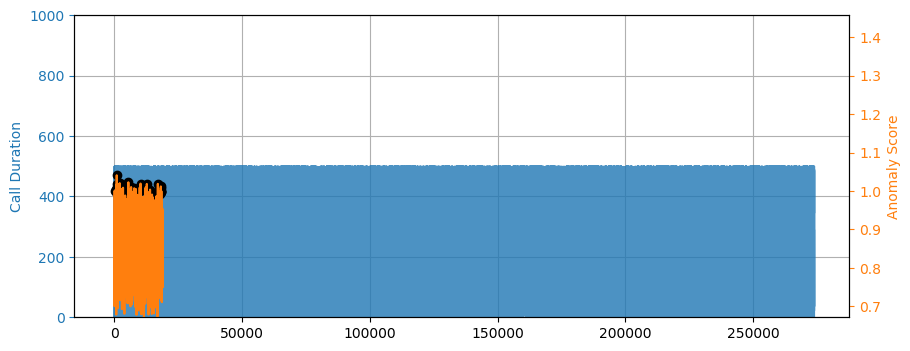

In [20]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(dataset)
dataset_subset = dataset[start:end]

ax1.plot(dataset['Duration'], color='C0', alpha=0.8)
ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('Call Duration', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(0, 1000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)